# Fashion MNIST Dataset
#### **Implementing a Tiny ResNet and Tiny GoogleNet and training it on fashion images**

Dataset Source: https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [1]:
# Import Require Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2023-05-03 15:06:35.005177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# GPU Configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config) 

2023-05-03 15:06:36.199419: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 15:06:36.200369: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-03 15:06:36.201576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-03 15:06:36.211142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 15:06:36.211470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [5]:
# Extract .zip file of the dataset
from zipfile import ZipFile

datasetZipPath = './dataset/FashionMNIST.zip'
datasetExtractPath = './dataset/'

with ZipFile(datasetZipPath, 'r') as zipObj:
    zipObj.extractall(path=datasetExtractPath)

In [ ]:
# Load Data
trainDataPath = './dataset/fashion-mnist_train.csv'
validDataPath = './dataset/fashion-mnist_test.csv'

trainData = pd.read_csv(trainDataPath)
validData = pd.read_csv(validDataPath)

In [6]:
# One-Hot Encoding Labels
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train = trainData['label'].values.reshape(-1, 1)
y_train = encoder.fit_transform(y_train).toarray()
y_valid = validData['label'].values.reshape(-1, 1)
y_valid = encoder.transform(y_valid).toarray()

In [7]:
# Reshapting X_train, and X_test
X_train = trainData.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 255
X_valid = validData.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 225

In [11]:
# Importing Required Packages, Libraries, and Functions
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Lambda 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.nn import local_response_normalization

In [12]:
# Creating Residual Unit Class
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.normalization = Lambda(local_response_normalization)
        self.main_layers = [
            Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
            self.normalization,
            self.activation,
            Conv2D(filters, 3, strides=1, padding='same', use_bias=False),
            self.normalization]
        self.skip_layers = []
        if strides > 1: 
            self.skip_layers = [
                Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                self.normalization]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

In [19]:
# Creating Model
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', input_shape=(28, 28, 1)))
model.add(Lambda(local_response_normalization))
model.add(Activation('relu'))
model.add(Dropout(rate=0.25))
model.add(ResidualUnit(filters=32, strides=2))
model.add(ResidualUnit(filters=32, strides=1))
model.add(Dropout(rate=0.25))
model.add(ResidualUnit(filters=64, strides=2))
model.add(ResidualUnit(filters=64, strides=1))
model.add(Dropout(rate=0.25))
model.add(ResidualUnit(filters=128, strides=2))
model.add(ResidualUnit(filters=128, strides=1))

model.add(Flatten())

model.add(Dense(250, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(10, activation='softmax'))

# Compiling the Model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Model Info.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
lambda_7 (Lambda)            (None, 28, 28, 16)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
residual_unit_6 (ResidualUni (None, 14, 14, 32)        14336     
_________________________________________________________________
residual_unit_7 (ResidualUni (None, 14, 14, 32)        18432     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)       

In [21]:
# Setting checkpoints 
checkpoint = ModelCheckpoint('./trained_model/tiny_resnet.h5', save_best_only=True)
earlyStopping = EarlyStopping(patience=14, restore_best_weights=True)

# Training
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[checkpoint, earlyStopping])

2023-05-03 15:31:17.066206: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/50
1875/1875 [==============================] - 29s 14ms/step - loss: 0.7161 - accuracy: 0.7496 - val_loss: 0.3655 - val_accuracy: 0.8662
Epoch 2/50
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3800 - accuracy: 0.8624 - val_loss: 0.2806 - val_accuracy: 0.8986
Epoch 3/50
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3172 - accuracy: 0.8881 - val_loss: 0.2556 - val_accuracy: 0.9075
Epoch 4/50
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2860 - accuracy: 0.8997 - val_loss: 0.2522 - val_accuracy: 0.9085
Epoch 5/50
1875/1875 [==============================] - 27s 15ms/step - loss: 0.2668 - accuracy: 0.9073 - val_loss: 0.2343 - val_accuracy: 0.9186
Epoch 6/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2487 - accuracy: 0.9127 - val_loss: 0.2237 - val_accuracy: 0.9162
Epoch 7/50
1875/1875 [==============================] - 27s 15ms/step - loss: 0.2313 - accuracy: 0.9168 - val_loss: 0.2314 -

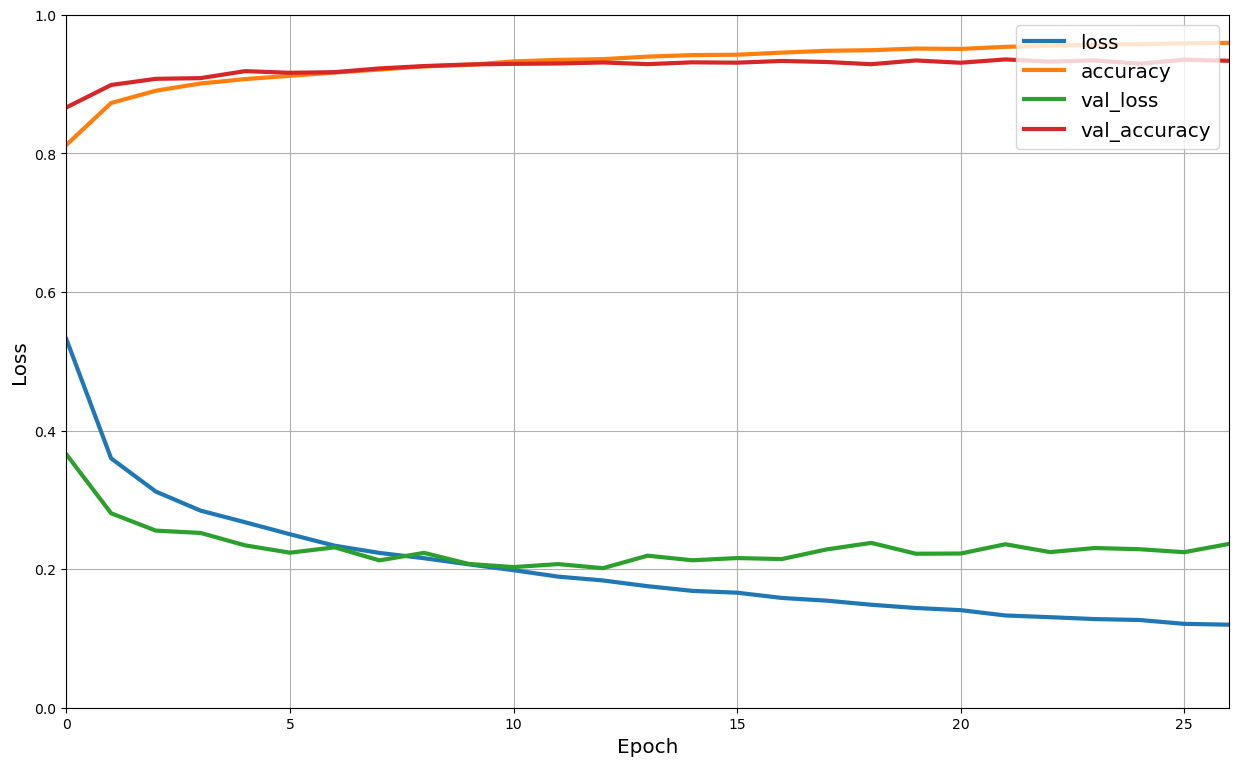

In [23]:
# Plotting Learning Curves
def plot_learning_curves(history, figsize=(15, 9)):
    plt.figure(figsize=figsize)
    history_pd = pd.DataFrame(history.history)
    plt.plot(history_pd, label=['loss', 'accuracy', 'val_loss', 'val_accuracy'], linewidth=3)
    plt.gca().set_ylim(0, 1)
    plt.gca().set_xlim(0, len(history_pd) - 1)
    plt.xlabel('Epoch', fontsize='x-large')
    plt.ylabel('Loss', fontsize='x-large')
    plt.legend(fontsize='x-large', loc=1)
    plt.grid(True)
    plt.show()

plot_learning_curves(history)